<Body>   
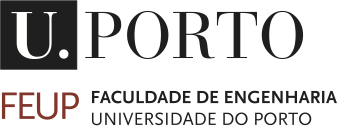   
<h1> <b>Signal Processing </b> </h1>
</Body>  

<br>**Fundamentos de Engenharia e Ciência de Dados**     <br>  Mestrado em Engenharia e Ciência de Dados <br><br> **Henrique Ribeiro - Ian Karkles - Vitor Pereira**  <br>
<br> Faculdade de Engenharia, Universidade do Porto <br>FEUP Dez. 2022 

<h1> <b>Electrocardiogram - Signal processing and feature extraction</b> </h1>


# Table of Contents

* [Introdução](#intro)
* [Importação dos dados e visualização dos sinais](#import)
* [Pré-processamento](#pre)
* [Análise e extração de features](#features)
* [Clustering](#cluster)


# Introduction<a class="anchor" id="intro"></a>

The "Abdominal and Direct Fetal Electrocardiogram" database contains fetal electrocardiogram (FECG) signals obtained from five women in labor, between 38 and 41 weeks pregnant. Each recording consists of four different signals from the maternal abdomen, and an electroencephalogram through the fetal head. The main purpose of capturing the signals is that they can be used to create new classification and clustering algorithms. In the medical context, especially in clinical examinations, anomalies can be detected before birth using simple algorithms. Feature transformation and selection techniques play an active role in this process.

# Data Importing and Data Visualization<a class="anchor" id="import"></a>

The frequency rate was 1Hz to 150Hz (synchronous sampling of all signals) and additional digital filtering was performed to remove power line interference (50Hz) and base drift. The sampling rate was 1 kHz and the resolution was 16 bits. The recording time for each of the simultaneous signals for the 5 women is 5 minutes. At a sample rate of 1 KHz, this results in a total of 300,000 reference points, per discrete signal, for each of the electrodes. As a consequence, 1.5 million signals were obtained for each woman in the study. Thus, the dataset consists of 25 columns. Each patient is represented by 5 columns, the first one for each patient being an electroencephalogram.

## Data Extraction

Transformation of the data in .edf format to Pandas dataframes (Python Data Analysis) and later arrays from the Numpy library

In [9]:
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.fftpack import fft
from scipy.signal import welch, chirp, spectrogram, stft, butter, filtfilt, periodogram
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler, StandardScaler

files = ['r01.edf','r04.edf','r07.edf','r08.edf','r10.edf']

In [12]:
df = pd.DataFrame()

for i in files:
        try:
                f = pyedflib.EdfReader(i)
        except:
                None      
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        sigbufs = np.zeros((n, f.getNSamples()[0]))
        for g in np.arange(n):
                sigbufs[g, :] = f.readSignal(g)
        df = df.append(pd.DataFrame(sigbufs))
df = df.reset_index(drop=True)
df = df.T
df

AttributeError: 'int' object has no attribute 'signals_in_file'

## Data Visualization

Visualization of the 25 signals of the 5 women, each with 300,000 samples

The data is displayed with the amplitude of the signal shown on the y-axis and the time on the x-axis. Using the graphs, it is possible to notice how much noise the signals have, either because of external interferences to the process, or because other parts of the woman's body can emit signals that generate noise.

In addition, it is possible to identify a pattern. The first graph in each sequence is different from the others, since it is an electroencephalogram of the fetus. The others refer to signals from electrocardiograms.

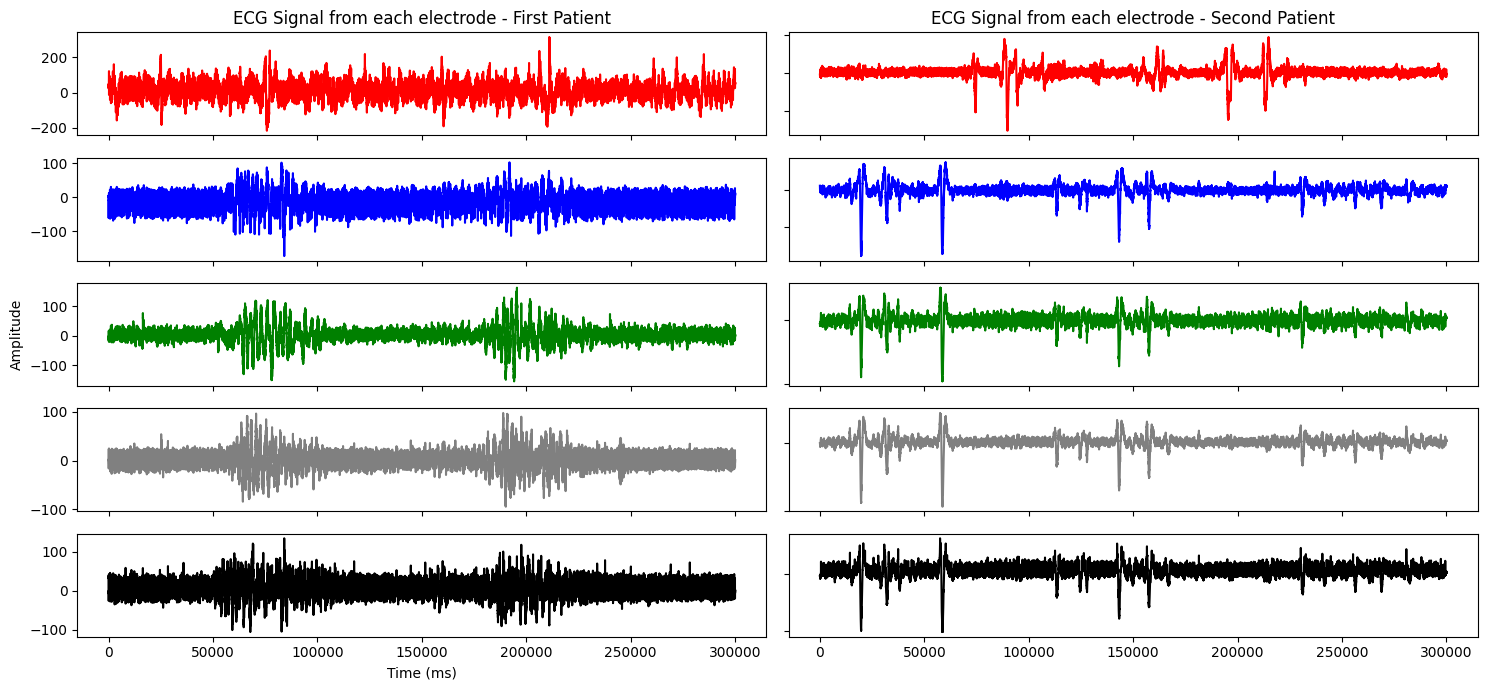

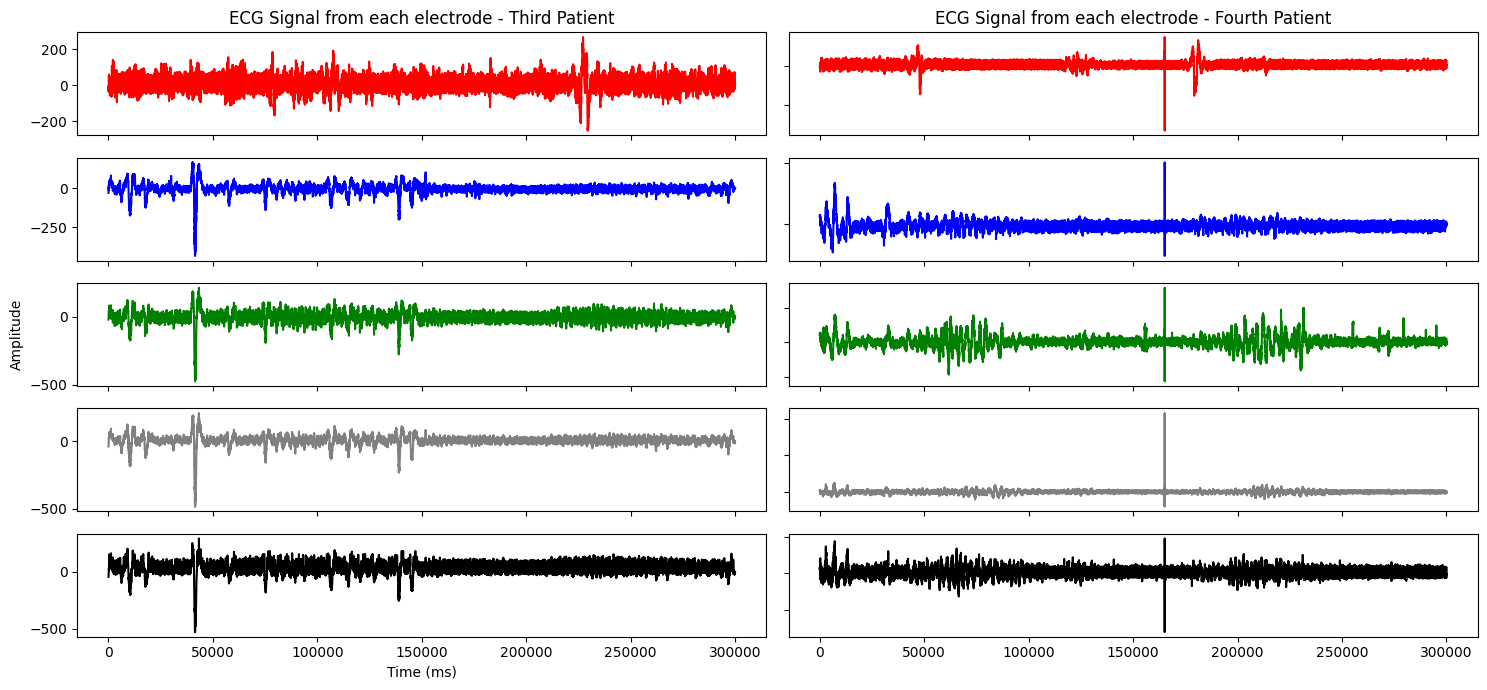

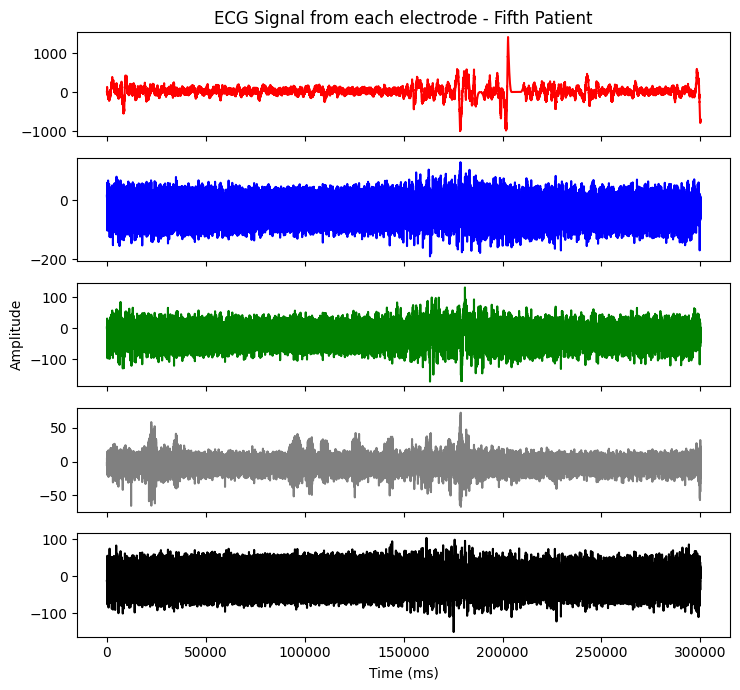

In [140]:
fig, axes = plt.subplots(5, 2, figsize = (15,7))
#first patient
axes[0, 0].plot(df[0], color='red')
axes[1, 0].plot(df[1], color='blue')
axes[2, 0].plot(df[2], color='green')
axes[3, 0].plot(df[3], color='grey')
axes[4, 0].plot(df[4], color='black')
axes[0, 0].set_title('ECG Signal from each electrode - First Patient', fontsize=12)
axes[2, 0].set_ylabel('Amplitude')
axes[4, 0].set_xlabel('Time (ms)')
#second patient
axes[0, 1].plot(df[5], color='red')
axes[1, 1].plot(df[6], color='blue')
axes[2, 1].plot(df[7], color='green')
axes[3, 1].plot(df[8], color='grey')
axes[4, 1].plot(df[9], color='black')
axes[0, 1].set_title('ECG Signal from each electrode - Second Patient', fontsize=12)
#remove axes duplicate ticks
for ax in axes.flat:
     ax.label_outer()
fig.tight_layout()

fig, axes = plt.subplots(5, 2, figsize = (15,7))
#third patient
axes[0, 0].plot(df[10], color='red')
axes[1, 0].plot(df[11], color='blue')
axes[2, 0].plot(df[12], color='green')
axes[3, 0].plot(df[13], color='grey')
axes[4, 0].plot(df[14], color='black')
axes[0, 0].set_title('ECG Signal from each electrode - Third Patient', fontsize=12)
axes[2, 0].set_ylabel('Amplitude')
axes[4, 0].set_xlabel('Time (ms)')
#fourth patient
axes[0, 1].plot(df[15], color='red')
axes[1, 1].plot(df[16], color='blue')
axes[2, 1].plot(df[17], color='green')
axes[3, 1].plot(df[18], color='grey')
axes[4, 1].plot(df[19], color='black')
axes[0, 1].set_title('ECG Signal from each electrode - Fourth Patient', fontsize=12)
#remove axes duplicate ticks
for ax in axes.flat:
     ax.label_outer()
fig.tight_layout()

fig, axes = plt.subplots(5, figsize = (7.5,7))
#fifth patient
axes[0].plot(df[20], color='red')
axes[1].plot(df[21], color='blue')
axes[2].plot(df[22], color='green')
axes[3].plot(df[23], color='grey')
axes[4].plot(df[24], color='black')
axes[0].set_title('ECG Signal from each electrode - Fifth Patient', fontsize=12)
axes[2].set_ylabel('Amplitude')
axes[4].set_xlabel('Time (ms)')
#remove axes duplicate ticks
for ax in axes.flat:
     ax.label_outer()
fig.tight_layout()


# Pre-Processing <a class="anchor" id="pre"></a>

## Filtering

In order to better analyze and display the signals we decided to apply a filter.  The chosen filter was a Bandpass filter. This filter is designed to transmit a specific range of frequencies while omitting others. This allows us to eliminate unwanted signals such as noise or interference, therefore improving the signal-to-noise ratio. Apart from this, it also isolates specific frequencies. The sampling rate used was of 100000 Hz and the lower and upper cut-off frequencies of the bandpass filter are 10 Hz and 50 Hz, respectively.

In [141]:
#function to define the filter
def bandpass(signal):
    fs = 100000
    cutoff_low = 10 
    cutoff_high = 50
    order = 2
    nyq =  0.5 * fs
    lowcut = cutoff_low/nyq
    highcut = cutoff_high/nyq
    b, a = butter(order, [lowcut, highcut], 'bandpass')
    y = filtfilt(b, a, signal, axis=0)
    return y

Below, the data with the applied filter is shown.

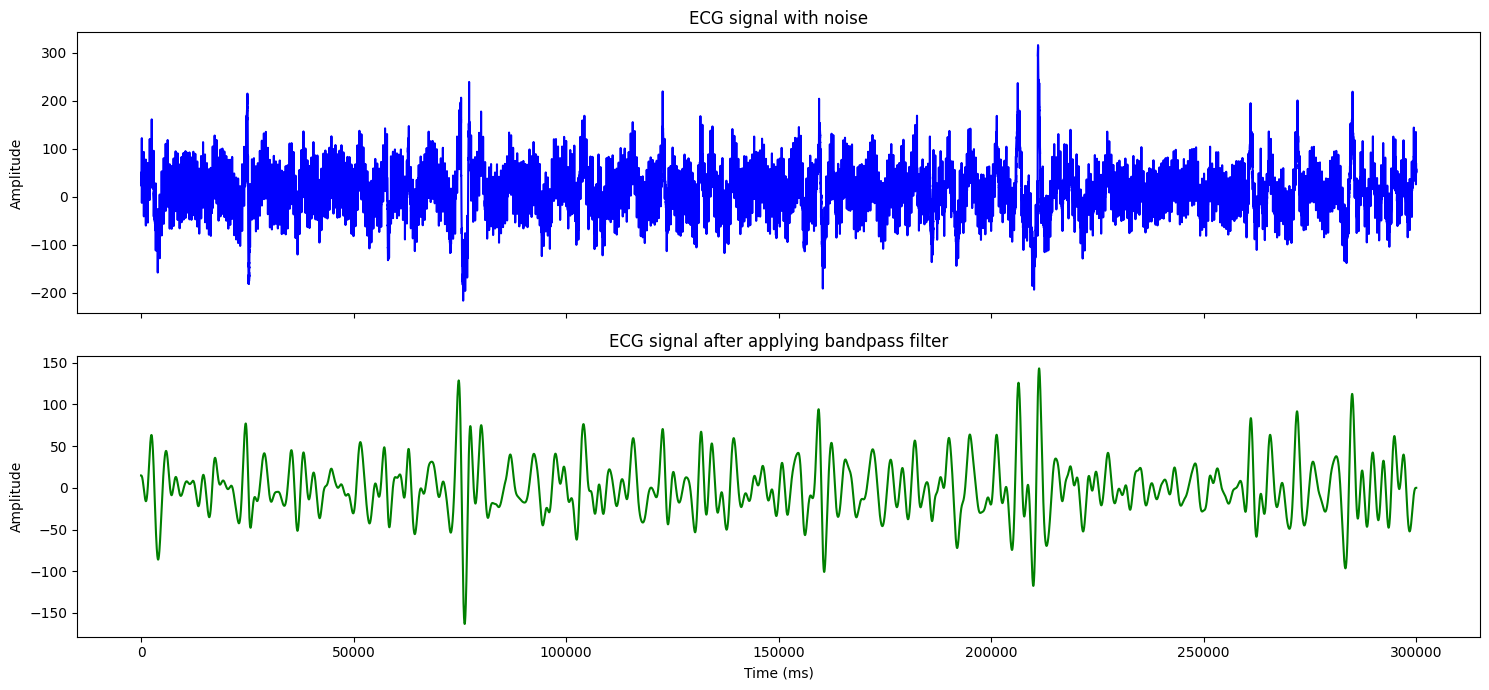

In [142]:
#plot eg to see the difference
fig, axes = plt.subplots(2, figsize = (15,7))
axes[0].plot(df[0], color = 'blue')
axes[1].plot(bandpass(df[0]), color = 'green')
axes[0].set_title('ECG signal with noise')
axes[1].set_title('ECG signal after applying bandpass filter')
axes[0].set_ylabel('Amplitude')
axes[1].set_ylabel('Amplitude')
axes[1].set_xlabel('Time (ms)')

for ax in axes.flat:
     ax.label_outer()
fig.tight_layout()

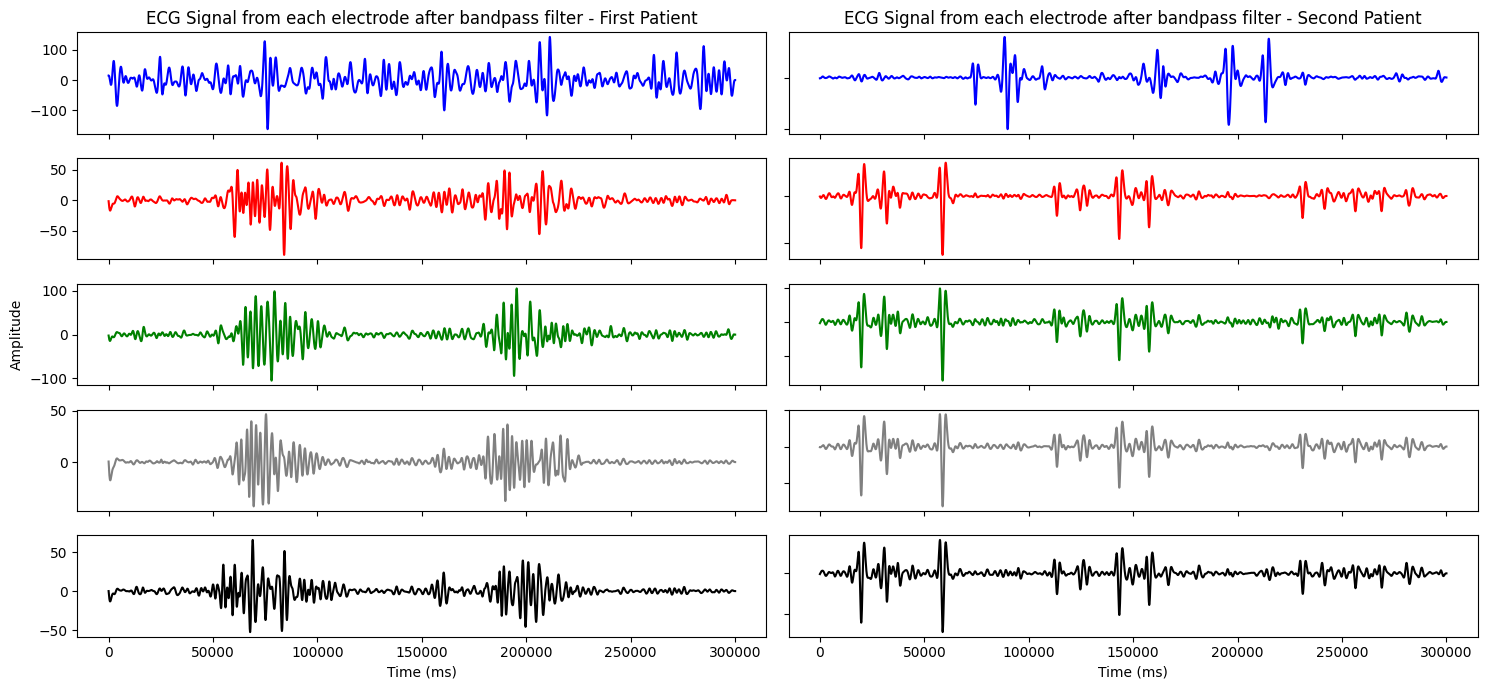

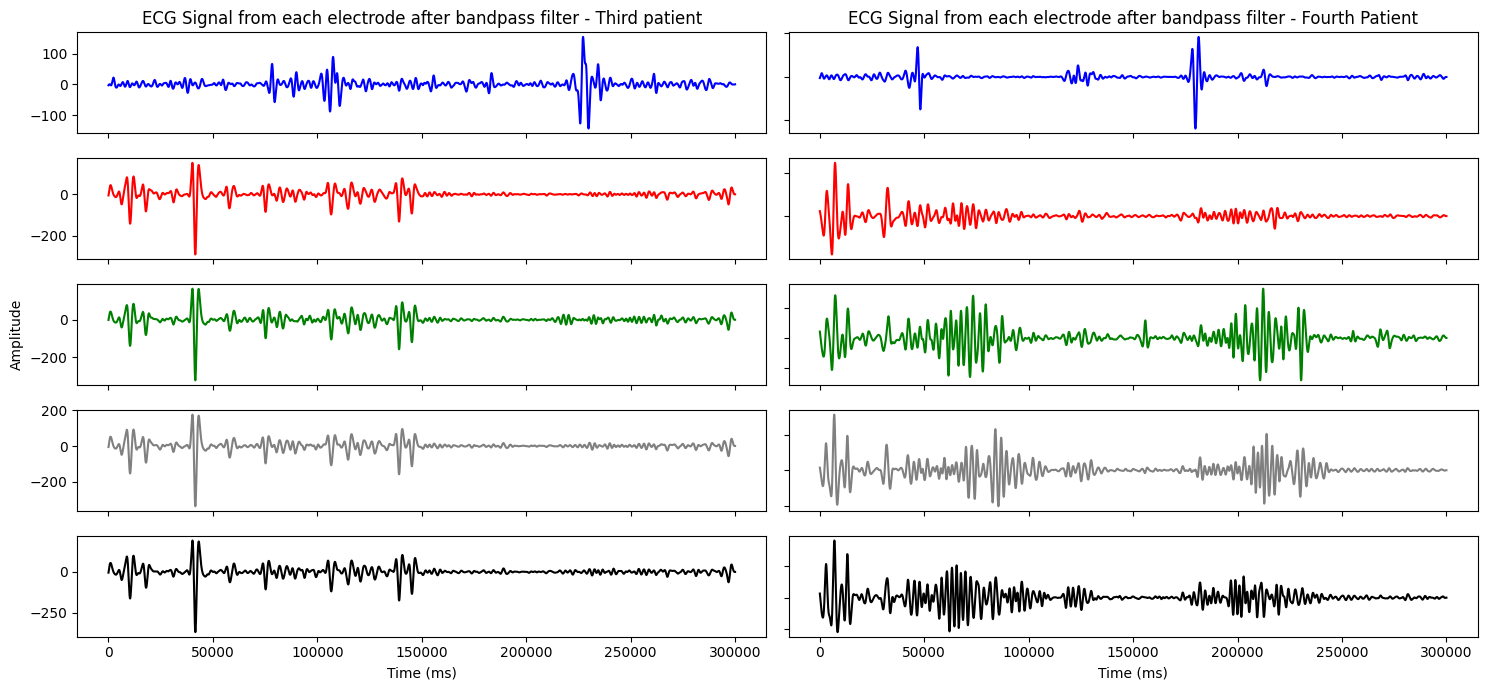

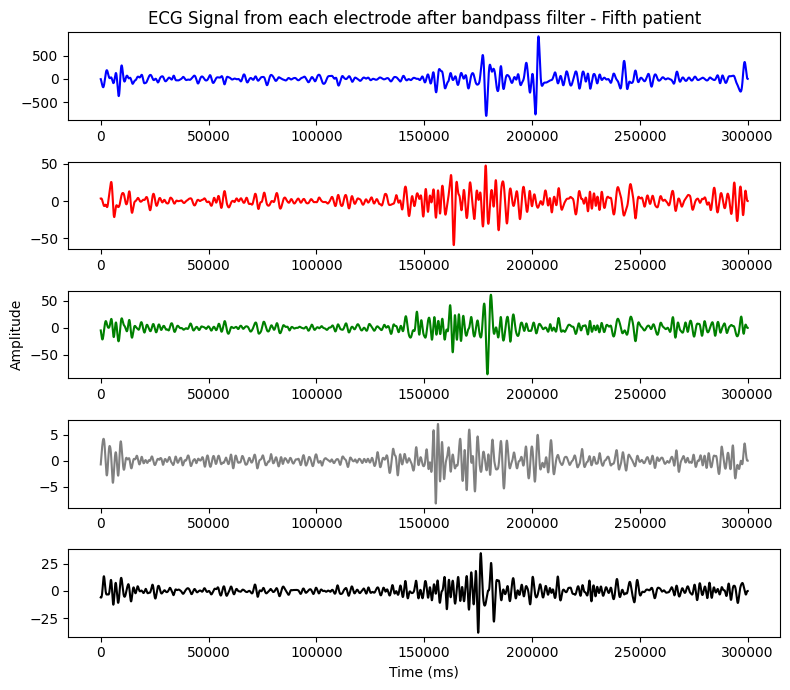

In [143]:
#all plots from the 5 patients
fig, axes = plt.subplots(5, 2, figsize = (15,7))
#first patient
axes[0, 0].plot(bandpass (df[0]), color='blue')
axes[1, 0].plot(bandpass (df[1]), color='red')
axes[2, 0].plot(bandpass (df[2]), color='green')
axes[3, 0].plot(bandpass (df[3]), color='grey')
axes[4, 0].plot(bandpass (df[4]), color='black')
axes[0, 0].set_title('ECG Signal from each electrode after bandpass filter - First Patient', fontsize=12)
axes[2, 0].set_ylabel('Amplitude')
axes[4, 0].set_xlabel('Time (ms)')
#second patient
axes[0, 1].plot(bandpass (df[5]), color='blue')
axes[1, 1].plot(bandpass (df[6]), color='red')
axes[2, 1].plot(bandpass (df[7]), color='green')
axes[3, 1].plot(bandpass (df[8]), color='grey')
axes[4, 1].plot(bandpass (df[9]), color='black')
axes[0, 1].set_title('ECG Signal from each electrode after bandpass filter - Second Patient', fontsize=12)
axes[4, 1].set_xlabel('Time (ms)')
#remove axis duplicate ticks
for ax in axes.flat:
     ax.label_outer()
fig.tight_layout()

fig, axes = plt.subplots(5, 2, figsize = (15,7))
#third patient
axes[0, 0].plot(bandpass (df[10]), color='blue')
axes[1, 0].plot(bandpass (df[11]), color='red')
axes[2, 0].plot(bandpass (df[12]), color='green')
axes[3, 0].plot(bandpass (df[13]), color='grey')
axes[4, 0].plot(bandpass (df[14]), color='black')
axes[0, 0].set_title('ECG Signal from each electrode after bandpass filter - Third patient', fontsize=12)
axes[2, 0].set_ylabel('Amplitude')
axes[4, 0].set_xlabel('Time (ms)')
#fourth patient
axes[0, 1].plot(bandpass (df[15]), color='blue')
axes[1, 1].plot(bandpass (df[16]), color='red')
axes[2, 1].plot(bandpass (df[17]), color='green')
axes[3, 1].plot(bandpass (df[18]), color='grey')
axes[4, 1].plot(bandpass (df[19]), color='black')
axes[0, 1].set_title('ECG Signal from each electrode after bandpass filter - Fourth Patient', fontsize=12)
axes[4, 1].set_xlabel('Time (ms)')
#remove axis duplicate ticks
for ax in axes.flat:
     ax.label_outer()
fig.tight_layout()

fig, axes = plt.subplots(5, figsize = (8,7))
#fifth patient
axes[0].plot(bandpass (df[20]), color='blue')
axes[1].plot(bandpass (df[21]), color='red')
axes[2].plot(bandpass (df[22]), color='green')
axes[3].plot(bandpass (df[23]), color='grey')
axes[4].plot(bandpass (df[24]), color='black')
axes[0].set_title('ECG Signal from each electrode after bandpass filter - Fifth patient', fontsize=12)
axes[2].set_ylabel('Amplitude')
axes[4].set_xlabel('Time (ms)')

fig.tight_layout()

In [144]:
df = bandpass(df)
df = pd.DataFrame(df)

# Analysis and Feature Extraction<a class="anchor" id="features"></a>

After removing the noise, we apply a function called features extraction, which extracts a series of features from a dataset into a dataframe.
The list of features to be extracted is defined in the FEATURES variable, which includes the minimum, maximum, mean, standard deviation, etc. The function starts by creating empty lists to store the extracted features. Then, using the dataframe, the function calculates the features in the time domain and the frequency domain.

The used features are the following:
    * MIN - minimum value in the time domain;
    * MAX - maximum value in the time domain;
    * MEAN - mean of the time domain;
    * RMS - root mean squared in the time domain;
    * VAR - variance in the time domain; 
    * STD - standard deviation in the time domain; 
    * QtyPeaks - quantity of peaks in the time domain;
    * MAX_f - maximum value in the frequency domain;
    * SUM_f - sum of the values in the frequency domain; 
    * MEAN_f - mean of the values in the frequency domain;
    * FFT 1 - absolute value of the first FFT;
    * FFT 2 - absolute value of the second FFT;
    * FFT 3 - absolute value of the third FFT;
    * MEAN_3P - mean value of the three highest peaks in the frequency domain

In [156]:
FEATURES = ['MIN','MAX','MEAN','RMS','VAR','STD','QtyPeaks',
            'MAX_f','SUM_f','MEAN_f','FFT_1','FFT_2','FFT_3','Mean_3P']

def features_extraction(df): 
    
    
    Min=[];Max=[];Mean=[];Rms=[];Var=[];Std=[];
    Max_f=[];Sum_f=[];Mean_f=[];FFT_1=[];FFT_2=[];FFT_3=[]; Mean_3P=[]; QtyPeaks=[];
    
    X = df.values
    ## TIME DOMAIN ##
    Min.append(np.min(X))
    Max.append(np.max(X))
    Mean.append(np.mean(X))
    Rms.append(np.sqrt(np.mean(X**2)))
    Var.append(np.var(X))
    Std.append(np.std(X))

    # Find the peaks in the signal
    peaks, _ = find_peaks(X)
    QtyPeaks.append(len(peaks))

    ## FREQ DOMAIN ##
    ft = fft(X)
    S = np.abs(ft**2)/len(df)
    Max_f.append(np.max(S))
    FFT_1.append(abs(ft[0]))
    FFT_2.append(abs(ft[1]))
    FFT_3.append(abs(ft[2]))
    amplitudes = np.abs(ft)
    amplitudes_sorted = np.sort(amplitudes)[::-1]
    highest_3 = amplitudes_sorted[:3]
    Mean_3P.append(sum(highest_3) / len(highest_3))
    Sum_f.append(np.sum(S))
    Mean_f.append(np.mean(S))



    #Create dataframe from features
    df_features = pd.DataFrame(index = [FEATURES], 
                               data = [Min,Max,Mean,Rms,Var,Std,QtyPeaks,
                                       Max_f,Sum_f,Mean_f,FFT_1,FFT_2,FFT_3, Mean_3P ])
    return df_features

In [157]:
# Initialize an empty list to store the feature vectors
feature_vectors = []

# Iterate over the indices of the `df` DataFrame
for i in range(len(df.columns)):
    # Extract the feature vector for the current index
    feature_vector = features_extraction(df[i]).T
    
    # Add the feature vector to the list of feature vectors
    feature_vectors.append(feature_vector)
    
# Concatenate all of the feature vectors into a single DataFrame
df_features = pd.concat(feature_vectors)

# Reset the index of the DataFrame
df_features.reset_index(drop=True, inplace=True)

# Convert the DataFrame to a NumPy array
df_array = np.array(df_features)


In [158]:
df_features

,MIN,MAX,MEAN,RMS,VAR,STD,QtyPeaks,MAX_f,SUM_f,MEAN_f,FFT_1,FFT_2,FFT_3,Mean_3P
0,-163.199214,143.135129,-0.000133,32.723084,1070.800222,32.723084,107.0,1.250537e+07,3.212401e+08,1070.800222,39.943797,2704.273479,5416.481134,1.712689e+06
1,-89.185850,61.524048,-0.065047,13.276493,176.261046,13.276334,112.0,1.114506e+06,5.287958e+07,176.265277,19514.116886,19531.942824,19585.222784,5.488030e+05
2,-105.234160,105.698285,-0.051424,20.063978,402.560571,20.063912,120.0,2.859140e+06,1.207690e+08,402.563216,15427.134058,15447.016446,15510.540069,8.786026e+05
3,-43.091788,46.618610,-0.069277,8.826502,77.902337,8.826230,119.0,8.232034e+05,2.337214e+07,77.907136,20783.077059,20802.129827,20858.567238,4.885343e+05
4,-52.608901,65.657242,-0.052137,10.503126,110.312945,10.502997,123.0,8.541581e+05,3.309470e+07,110.315663,15641.133178,15657.028376,15705.909109,5.041093e+05
5,-498.059806,391.799937,0.012095,68.696224,4719.171092,68.696223,107.0,3.548496e+07,1.415751e+09,4719.171238,3628.549974,3643.462950,3705.999150,3.154158e+06
6,-251.925775,142.405586,-0.030869,30.605628,936.703529,30.605613,110.0,6.495517e+06,2.810113e+08,936.704482,9260.660993,9287.539377,9384.085234,1.361168e+06
7,-341.765008,195.353949,0.032883,39.926265,1594.105544,39.926251,117.0,1.078975e+07,4.782320e+08,1594.106625,9864.995861,9862.881862,9866.923325,1.774922e+06
8,-326.234204,176.417231,-0.004413,38.495271,1481.885856,38.495271,114.0,8.796015e+06,4.445658e+08,1481.885875,1323.771539,1409.894773,1630.885378,1.620705e+06
9,-359.993654,204.840192,0.035468,44.033498,1938.947702,44.033484,115.0,1.261410e+07,5.816847e+08,1938.948960,10640.541282,10644.220250,10655.629689,1.938469e+06


Here, a periodogram displaying the power spectral density of various signals is shown. It has been plotted together in order to see that they're similar but not equal.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1852: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


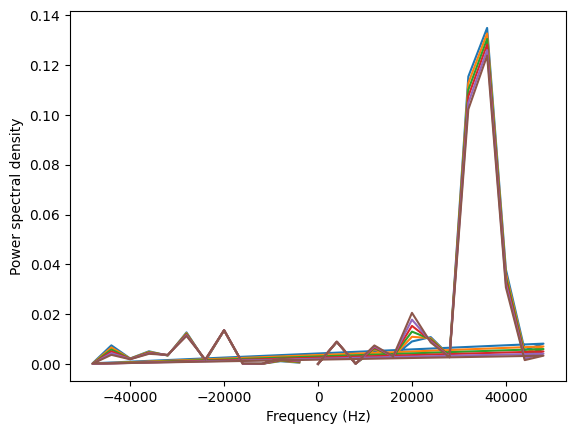

In [284]:
X = df.values
ft = fft(X)
ft2 = pd.DataFrame(ft)


# Compute the power spectral density of the signal

for i in range(0,26,5):
    f, psd = periodogram(ft[i], fs=100000)
    plt.plot(f, psd)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density')


And here, a plot of FFTs for an electrode of each womem are displayed. Once again, they are similar but not equal. 

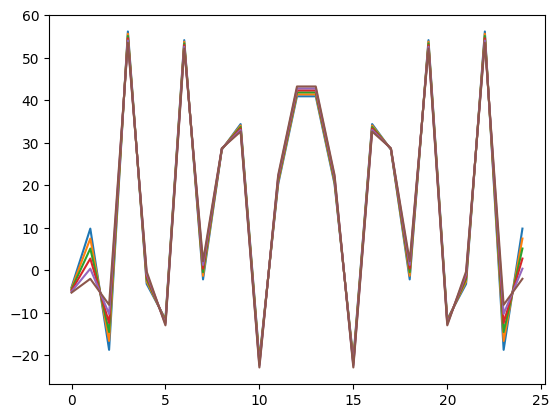

In [283]:
### FFT Plots for a electrode of each woman - Together in order to see that they're similar but not equal

for i in range(0,26,5):
    plt.plot(ft[i])



# Clustering<a class="anchor" id="cluster"></a>

As for  modeling and classification, the predictive K-Nearest Neighbours (KNN) model was used. The number of clusters defined was 2, since we have 20 signals from electrocardiograms and 5 from fetal encephalograms. Thus, one would expect the predictive model to cluster 20 signals in one of the clusters and 5 in the other. However, the efficiency of this predictive model was not the best and 24 signals were recorded in one of the clusters and 1 in the rest.
The predictive model in question was also tested after normalizing the data, but the same results were recorded. One would expect that by using other predictive models we would have reached better results.

In [263]:
n = 2
k_means = KMeans(n_clusters=n)

# min_max_scaler = StandardScaler() 
# x_scaled = min_max_scaler.fit_transform(df_features) 
# df_normalized = pd.DataFrame(x_scaled)
# normalized_array = np.array(df_normalized)

k_means.fit(df_array)

centroids = k_means.cluster_centers_
labels= k_means.labels_

cluster 0
In this cluster we have 24 signals


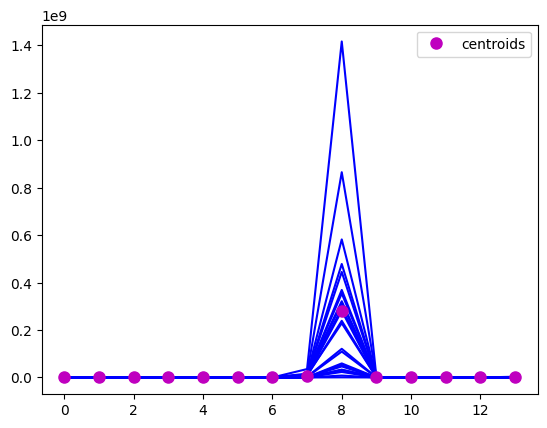

cluster 1
In this cluster we have 1 signals


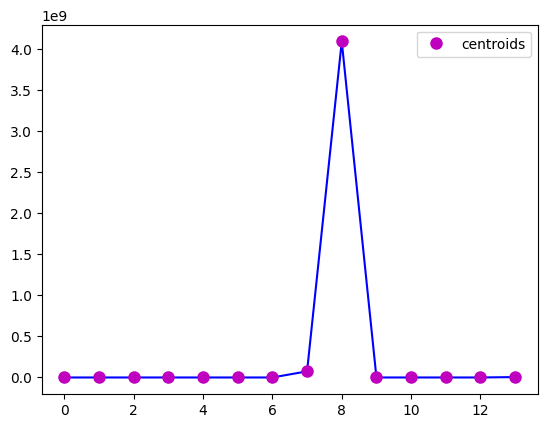

In [264]:
# Let's now plot the signals grouped in clusters...

for i in range(0,n):

    n_i = len(df_array[labels == i]) # number of elements in cluster i

    print("cluster " + str(i))
    print("In this cluster we have "+ str(n_i)+" signals")
    
    #plt.figure(figsize=(10,10))
    for k in range(0,n_i):
        plt.plot(df_array[labels==i][k],'b')
    
    plt.plot(centroids[i],'mo',markersize=8, label='centroids')
    plt.legend(loc='best')
    plt.show()

# Conclusion

By studying the signals taken from electrocardiograms and encephalograms, it was possible to obtain what was initially proposed in this project.
After extracting the features of the captured signals, whether in the time or frequency domain, we were able to use them in the K-Nearest Neighbours predictive model and they are also available to be used in other predictive models, which can be considered very interesting in the medical context, since it will allow us to detect anomalies and problems before birth. 

In future studies, we believe that it would be interesting to have access to more data, specifically signals from electrocardiograms and encephalograms of pregnant women with children who will be healthy and womemwith children born with anomalies.

In addition, we believe that more predictive models should be applied in order to obtain better predictions than those obtained through the K-Nearest Neighbors.